In [1]:
import functools as ft
import io
import itertools
import json
from pathlib import Path

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.axes import Axes
from tqdm.notebook import tqdm

import matplotlib.font_manager as fm

In [2]:
sns.set_theme(
    "paper",
    "darkgrid",
    font_scale=1.2,
    rc={
        "font.family": "serif",
        "font.serif": ["CMU Concrete"],
        "axes.facecolor": ".95",
        "mathtext.fontset": "cm",
        "text.usetex": False,
    },
)
%config InlineBackend.figure_formats = ['svg']

In [3]:
dataset_name = "congress"
# or: 
# dataset_name = "karate"
n_data = 50 if dataset_name == "congress" else 1024


name_map = {
  "greedy": "Greedy",
  "celf": "CELF",
  "greedy-cb": "Greedy+CB",
  "celf-cb": "CELF+CB",
}

if dataset_name == "congress":
  del name_map["greedy"]

df = pd.DataFrame()

for algo_name in name_map.keys():
  for id in range(1, n_data + 1):
    df1 = pd.read_csv(f"../results/{dataset_name}/{algo_name}/{id}.txt", header=None, sep=" ")
    df1.columns = ["vertex", "sample_complexity"]
    eval_df1 = pd.read_csv(f"../results/{dataset_name}/{algo_name}/{id}_eval.txt", header=None)
    eval_df1.columns = ["evaluation"]
    df1 = pd.concat([df1, eval_df1], axis=1)
    df1["algo_name"] = name_map[algo_name]
    df1["id"] = id
    df1["dataset_name"] = dataset_name
    df1["step"] = df1.index + 1

    df = pd.concat([df, df1], axis=0)

In [4]:
# infer the step cost of greedy when not available
edf = df[df['algo_name'] == 'CELF']
edf = edf[edf['step'] == 1]
greedy_step_cost = edf['sample_complexity'].min()

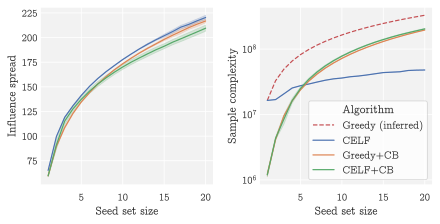

In [5]:
color_map = {
  "greedy": sns.color_palette()[3],
  "celf": sns.color_palette()[0],
  "greedy-cb": sns.color_palette()[1],
  "celf-cb": sns.color_palette()[2],
}

fig, axes = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")
fig.get_layout_engine().set(wspace=0.066)
axes = axes.flatten()

palette = [color_map[x] for x in name_map.keys()]
# palette

if 'greedy' not in name_map:
    steps = np.arange(20) + 1
    axes[1].plot(steps, steps * greedy_step_cost,
                 color=color_map['greedy'],
                 linestyle="--",
                 label="Greedy (inferred)")
sns.lineplot(data=df, x="step", y="evaluation", hue="algo_name", palette=palette, legend=False, errorbar=("sd", 1), ax=axes[0])
sns.lineplot(data=df, x="step", y="sample_complexity", hue="algo_name", palette=palette, legend=True, errorbar=("sd", 1), ax=axes[1])
axes[0].set_xlabel("Seed set size")
axes[1].set_xlabel("Seed set size")
axes[0].set_ylabel("Influence spread")
axes[1].set_ylabel("Sample complexity")
axes[0].tick_params(axis='y', which='major', pad=-2)
axes[1].tick_params(axis='y', which='major', pad=-2)
if dataset_name == "congress":
    axes[1].set_yscale('log')
axes[1].legend(title="Algorithm", facecolor="white")

fig.savefig(f"../results/{dataset_name}_compare.pdf", bbox_inches="tight", facecolor=fig.get_facecolor(),
    edgecolor="none")